In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras import models
from keras import layers
import pickle
import matplotlib.pyplot as plt

In [2]:
input_folder_path='../input_data/'
output_folder_path = '../trained_model/'
input_file_name = 'movies_metadata.csv'

In [24]:
num_of_genres=10
num_words=10000

# 1. Data preparation

## 1.1 Reading movies data

We import the csv file with the movies information.

In [3]:
movies = pd.read_csv(input_folder_path+input_file_name, 
                     usecols= ['id','title', 'overview', 'genres'],
                     dtype={"id": str, "title": str, "overview": str},
                     converters={"genres": literal_eval})

In [4]:
movies.shape

(45466, 4)

## 1.2 Filtering

We remove useless rows:
- with title value missing
- with overview value too short
- with an empty genres list

In [5]:
movies = movies[movies.title.notna()]

In [6]:
movies = movies[movies.overview.str.len()>50]

In [7]:
movies = movies[movies.genres.apply(len)>0]

In [8]:
movies.shape

(41910, 4)

## 1.3 Chosing an unique genre

The movies dataset has, for each movie, a list of genres with length between 1 and 3. There are 20 different genres.

In [9]:
all_genres = [element for list_ in movies.genres for element in list_]

In [10]:
genres_freq = dict(Counter([element["name"] for element in all_genres]).most_common())

In [11]:
len(genres_freq)

20

In [12]:
genres_freq

{'Drama': 19889,
 'Comedy': 12652,
 'Thriller': 7543,
 'Romance': 6638,
 'Action': 6526,
 'Horror': 4625,
 'Crime': 4249,
 'Documentary': 3824,
 'Adventure': 3458,
 'Science Fiction': 3007,
 'Family': 2712,
 'Mystery': 2445,
 'Fantasy': 2275,
 'Animation': 1896,
 'Foreign': 1579,
 'Music': 1566,
 'History': 1375,
 'War': 1306,
 'Western': 1027,
 'TV Movie': 744}

In scope of this project, we want to reduce the number of possible genres to `num_of_genres`, removing the less common ones.
So we define a subset of genre values as the `num_of_genres` most common and we filter out, for each movie, the genres not included in this short list.

In [14]:
print(num_of_genres)

10


In [15]:
genres_list = list(genres_freq.keys())

In [16]:
genres_subset = genres_list[:num_of_genres]

In [17]:
genres_subset

['Drama',
 'Comedy',
 'Thriller',
 'Romance',
 'Action',
 'Horror',
 'Crime',
 'Documentary',
 'Adventure',
 'Science Fiction']

In [18]:
movies['accepted_genres'] = movies.genres.apply(
    lambda x: list(set([elem_["name"] for elem_ in x ])\
                  .intersection(set(genres_subset))))

We now have some movies for which, because this filtering, there is no genre associated. We remove them and we create a new dataframe `movies_reduced`.

In [19]:
movies[movies.accepted_genres.apply(len)==0].shape, movies.shape

((1429, 5), (41910, 5))

In [20]:
movies_reduced = movies[movies.accepted_genres.apply(len)>0].copy()

Finally, we want to have just one genre per movie, so we define the column `unique genre` as the first genre of the list.

In [21]:
movies_reduced['unique_genre'] = movies_reduced.accepted_genres.apply(lambda x: x[0])

In [22]:
movies_reduced.head(3)

,genres,id,overview,title,accepted_genres,unique_genre
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,"Led by Woody, Andy's toys live happily in his ...",Toy Story,[Comedy],Comedy
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,When siblings Judy and Peter discover an encha...,Jumanji,[Adventure],Adventure
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,A family wedding reignites the ancient feud be...,Grumpier Old Men,"[Romance, Comedy]",Romance


In [23]:
movies_reduced.shape

(40481, 6)

We finally have our data set ready!

## 1.4 Vectorization

Overview values are strings, we want to tokenize them before they are given as input to the model. We set a vocabulary length `num_words` to consider only the most common words.

In [26]:
print(num_words)

10000


In [27]:
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',)

In [28]:
tokenizer.fit_on_texts(movies_reduced.overview)

In [29]:
len(tokenizer.word_index)

81888

In [30]:
tokenized_overviews = tokenizer.texts_to_sequences(movies_reduced.overview.str.split())

We transform genre value to the correspondant index of the genres list, creating the genre label

In [31]:
genre_labels = movies_reduced.unique_genre.apply(lambda x: genres_subset.index(x)).tolist()

# 2. The model

## 2.1 Data encoding

We want to one-hot encode both tokenized overviews and genre indexes.

In [34]:
vectorized_overviews = np.zeros((len(tokenized_overviews), num_words), bool)

In [35]:
for i, tokenized_ov in enumerate(tokenized_overviews):
    vectorized_overviews[i, tokenized_ov]=True

In [36]:
vectorized_overviews

array([[False,  True, False, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       ...,
       [False,  True,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False]])

In [37]:
genre_one_hot = to_categorical(genre_labels)

In [38]:
genre_one_hot

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

## 2.2 Split train test

We can now split the input set in train and test. Part of the train one will be used as validation set.

In [40]:
test_size = 10000

In [41]:
vectorized_overviews_train = vectorized_overviews[:-test_size]

In [42]:
vectorized_overviews_test = vectorized_overviews[-test_size:]

In [43]:
len(vectorized_overviews_train),len(vectorized_overviews_test)

(30481, 10000)

In [44]:
genre_one_hot_train = genre_one_hot[:-test_size]
genre_one_hot_test = genre_one_hot[-test_size:]

In [45]:
len(genre_one_hot_train),len(genre_one_hot_test)

(30481, 10000)

## 2.3 Architecture of the NN

The definition of the architecture of the network is the setting of all the hyperparameters (number of layers, number of nodes, activation functions, ...).

In [46]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(num_words,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_of_genres, activation='softmax'))

2021-07-10 18:26:03.434446: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-10 18:26:03.434661: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-10 18:26:03.435760: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## 2.4 Compiling

We define the optimizer, loss function and the evaluation metrics.

In [47]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 2.5 Training

Finally we train the Net

In [48]:
history = model.fit(vectorized_overviews_train,
                    genre_one_hot_train,
                    epochs=10,
                    batch_size=512,
                    validation_split=0.1)

2021-07-10 18:26:35.167482: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-10 18:26:35.184900: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299965000 Hz


Epoch 1/10
54/54 [==============================] - 2s 37ms/step - loss: 1.9848 - accuracy: 0.3047 - val_loss: 1.5854 - val_accuracy: 0.4559
Epoch 2/10
54/54 [==============================] - 2s 32ms/step - loss: 1.3393 - accuracy: 0.5404 - val_loss: 1.5633 - val_accuracy: 0.4549
Epoch 3/10
54/54 [==============================] - 3s 55ms/step - loss: 1.0595 - accuracy: 0.6435 - val_loss: 1.5690 - val_accuracy: 0.4654
Epoch 4/10
54/54 [==============================] - 4s 66ms/step - loss: 0.8545 - accuracy: 0.7201 - val_loss: 1.7148 - val_accuracy: 0.4467
Epoch 5/10
54/54 [==============================] - 4s 70ms/step - loss: 0.7043 - accuracy: 0.7740 - val_loss: 1.9164 - val_accuracy: 0.4280
Epoch 6/10
54/54 [==============================] - 4s 70ms/step - loss: 0.5781 - accuracy: 0.8121 - val_loss: 2.0266 - val_accuracy: 0.4316
Epoch 7/10
54/54 [==============================] - 4s 67ms/step - loss: 0.4570 - accuracy: 0.8598 - val_loss: 2.2045 - val_accuracy: 0.4159
Epoch 8/10
54

## 2.6 NN evaluation

We evaluate the NN performance on the training and validation sets, looking both at the loss function and accuracy metrics.

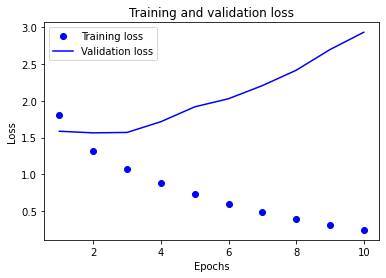

In [49]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

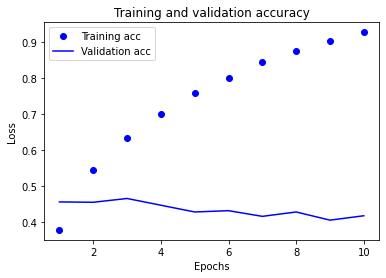

In [50]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Then we evaluate th performance on the test set.

In [51]:
model.evaluate(vectorized_overviews_test, genre_one_hot_test)

313/313 [==============================] - 3s 9ms/step - loss: 2.8323 - accuracy: 0.4158


[2.832263946533203, 0.415800005197525]

# 3. Saving the outputs

We save the outputs to make them available to the application.

In [52]:
model.save(output_folder_path+'nn/')

2021-07-10 18:28:34.085196: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../trained_model/nn/assets


In [53]:
with open(output_folder_path+'genres_subset.txt', "wb") as fp:
    pickle.dump(genres_subset, fp)

with open(output_folder_path+'tokenizer.txt', "wb") as fp:
    pickle.dump(tokenizer, fp)